In [4]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
import os

os.environ["TF_CP_MIN_LOG_LEVEL"] = "2"

In [5]:
# Load data
company = 'GOOGL'

start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = web.DataReader(company, 'yahoo', start, end)

In [6]:
# Prepare Data
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.array(y_train)

In [7]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

model.save('models/model.h5')


model = load_model('models/model.h5')

2022-01-17 17:27:22.935038: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25
61/61 [==============================] - 3s 24ms/step - loss: 0.0212
Epoch 2/25
61/61 [==============================] - 2s 25ms/step - loss: 0.0041
Epoch 3/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0030
Epoch 4/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0032
Epoch 5/25
61/61 [==============================] - 2s 25ms/step - loss: 0.0026
Epoch 6/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0028
Epoch 7/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0025
Epoch 8/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0025
Epoch 9/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0025
Epoch 10/25
61/61 [==============================] - 2s 25ms/step - loss: 0.0025
Epoch 11/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0023
Epoch 12/25
61/61 [==============================] - 2s 26ms/step - loss: 0.0026
Epoch 13/25
61/61 [==================

In [8]:
# Load Test Data

test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime(2021, 6, 1)

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']))

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scalar.transform(model_inputs)

In [9]:
# Make Predictions on Test Data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scalar.inverse_transform(predicted_prices)

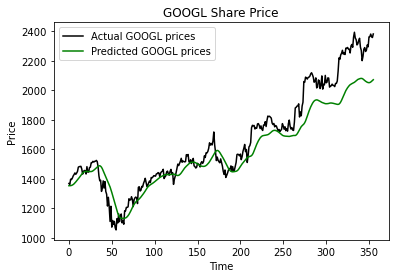

In [10]:
# Plot Predictions

plt.plot(actual_prices, color='black', label=f'Actual {company} prices')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} prices')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()